In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from scipy.stats import skewnorm
from scipy.stats import linregress
import string
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import tools
from scipy.stats import binned_statistic
import tqdm


pd.set_option("mode.chained_assignment", None)

dep_l = pickle.load(open('../pickles/line_depths_dict.p','rb'))

# Make a flat dictionary of all transects

In [2]:
flat_dict = {}

for key in dep_l:

    station = dep_l[key]
    
    for date in station:
        
        series = np.array(list(station[date]))
        
        flat_dict[(key,date)] = series

In [3]:
def make_training_df(flat_key):
    
    long_list = []
    
    for key in flat_dict.keys():
        
        if key != flat_key:
            
            series = flat_dict[key]

            n_series = (series - np.nanmean(series))

            std = np.nanstd(n_series)

            ns_series = n_series/std
        
            long_list .append({'std':std,
                         'mean':np.nanmean(series),
                         'norm':ns_series,
                                })
            
    training_df = pd.DataFrame(long_list)
    
    return(training_df)

cross_val_list = []

for trial_key in tqdm.tqdm(flat_dict.keys()):
    
    transect = flat_dict[trial_key]
    bins = np.linspace(0,np.nanmax(transect),10)
    bw = np.diff(bins)[0]    
    
    hist, bin_edges = np.histogram(transect,bins=bins, density=True)


    training_df = make_training_df(trial_key)

    training_statistics = tools.get_statistics(training_df)
    
    bc, ft = tools.depth_distribution_from_depth(np.nanmean(transect),bins,training_statistics)
    
    ######
    
    length_of_transect = np.count_nonzero(np.nan_to_num(transect))

    rmse_val = np.sqrt(np.nanmean((ft-hist*bw)**2))

    cross_val_list.append({'rmse':rmse_val,
                           'mean_depth':np.nanmean(transect),
                           'transect_length':length_of_transect,
                           'month':trial_key[1].month,
                           'station':trial_key[0]})

cv_df = pd.DataFrame(cross_val_list)

cv_df

  0%|          | 0/499 [00:00<?, ?it/s]/home/robbie/Dropbox/sub_km/notebooks/tools.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  CV = np.linalg.lstsq(np.array(df['mean'])[:, np.newaxis], df['std'])[0][0]
100%|██████████| 499/499 [02:39<00:00,  3.13it/s]


,rmse,mean_depth,transect_length,month,station
0,0.053354,26.882353,51,6,7
1,0.030898,15.588235,51,9,7
2,0.055891,16.372549,51,10,7
3,0.060487,18.843137,51,11,7
4,0.072335,19.137255,51,12,7
...,...,...,...,...,...
494,0.038131,46.188119,101,6,5
495,0.023904,43.637363,91,6,5
496,0.055658,25.603960,101,7,5
497,0.027450,25.029703,101,11,5


In [4]:
# pickle.dump(cv_df, open('pickles/cv_df.p','wb'))
cv_df = pickle.load(open('../pickles/cv_df.p', 'rb'))

In [5]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,8))

long_rmse = cv_df['rmse'][cv_df['transect_length'] > 70]
short_rmse = cv_df['rmse'][cv_df['transect_length'] < 70]

print(len(short_rmse), len(long_rmse))

bins = np.linspace(0,0.3,20)
bw = np.diff(bins)[0]

print(f'Mean of long rmse:{np.nanmean(long_rmse)}\n Mean of short rmse:{np.nanmean(short_rmse)}')
print(f'percent difference: {100*(np.nanmean(short_rmse)-np.nanmean(long_rmse))/np.nanmean(short_rmse)}')
print('#########################')

(n,bins,p) = ax1.hist(long_rmse,
                      color='#d8b365',alpha=0.5,label='Long Transects',bins=bins,density=True)
ax1.step(x=[0]+[b+bw for b in bins[:-1]], y=[0]+list(n),color='darkorange',alpha=0.5)

(n,bins,p) = ax1.hist(short_rmse,
                      color='#5ab4ac',alpha=0.5,label='Short Transects',bins=bins,density=True)
ax1.step(x=[b+bw for b in bins[:-1]], y=n,color='darkblue',alpha=0.5)

ax1.set_ylabel('Probability Density', fontsize='x-large')
ax1.set_xlabel('Transect RMSE', fontsize='x-large')

ax1.legend(fontsize='x-large')

### AX2 ###

statistic, bin_edges, bn = binned_statistic(cv_df['mean_depth'],cv_df['rmse'],bins=np.arange(0,61,10))
print((np.max(statistic)-np.min(statistic))/np.min(statistic))
ax2.bar(np.arange(5,61,10),statistic,alpha=0.2,width=10,label='Binned Mean',edgecolor='darkblue')

ax2.scatter(cv_df['mean_depth'],cv_df['rmse'],alpha=0.5, label='Single Transects')

ax2.legend(fontsize='x-large')
      

ax2.set_ylabel('Transect RMSE', fontsize='x-large')
ax2.set_xlabel('Transect Mean Depth (cm)', fontsize='x-large')

### AX3 ###

month_rmses = [np.mean(cv_df['rmse'][cv_df['month'] == month]) for month in range(1,13)]

month_num_transects = [np.count_nonzero(cv_df['rmse'][cv_df['month'] == month]) for month in range(1,13)]

for month, mean_rmse, month_num in zip(range(1,13), month_rmses, month_num_transects):
    
    ax3.annotate(f'n = {month_num} ',xy=(0.09+month,mean_rmse),
                 xycoords='data', rotation=90, va='top', ha='center',fontsize='large')

ax3.bar(range(1,13), month_rmses,color='lightblue', edgecolor='darkblue')

ax3.set_ylabel('Mean RMSE', fontsize='x-large')
ax3.set_xlabel('Month of Transect', fontsize='x-large')
ax3.set_xticks(range(1,13))
ax3.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],rotation=90)

### AX4 ###

station_num_transects = []
station_mean_rmse = []

station_num_transects_short = []
station_mean_rmse_short = []


for key in dep_l.keys():
    
    mean_transect_length = np.mean(cv_df['transect_length'][cv_df['station'] == key])
    
    if mean_transect_length > 70:
    
        station_num_transects.append(len(cv_df['transect_length'][cv_df['station'] == key]))
        station_mean_rmse.append(np.median(cv_df['rmse'][cv_df['station'] == key]))
        
    else:
        station_num_transects_short.append(len(cv_df['transect_length'][cv_df['station'] == key]))
        station_mean_rmse_short.append(np.median(cv_df['rmse'][cv_df['station'] == key]))
        
for ax, letter in zip([ax1,ax2,ax3,ax4], string.ascii_letters):
    ax.annotate(f"({letter})",xy=(-0.05,1.05),
                xycoords='axes fraction', fontsize='xx-large',
               va='center',ha='center')
    
ax4.scatter(station_num_transects_short,station_mean_rmse_short,marker='o',color='green',label='Short Transects')

ax4.scatter(station_num_transects,station_mean_rmse,marker="^",color='magenta', label='Long Transects')

ax4.set_ylabel('Median RMSE of \nStation Transects', fontsize='x-large')
ax4.set_xlabel('Number of Station Transects', fontsize='x-large')

ax4.legend(fontsize='x-large')

for ax in [ax2,ax4]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

plt.subplots_adjust(wspace=0.1)

plt.savefig('../figures/fig_4.png', bbox_inches='tight',dpi=500)
plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/sub-km-snow-depth-dist/figs/fig4.png', bbox_inches='tight',dpi=500)

336 163
Mean of long rmse:0.05325109081647704
 Mean of short rmse:0.05727041785806507
percent difference: 7.018155606179166
#########################
1.095479198148925


In [46]:
np.nanmean(np.concatenate([month_rmses[:6],month_rmses[8:]]))

0.05546195858622397

In [47]:
summer = np.nanmean(month_num_transects[6:8])
other = np.nanmean(np.concatenate([month_num_transects[:6],month_num_transects[8:]]))

print(other)

49.0


In [48]:
from scipy.stats import spearmanr

spearmanr(list(station_num_transects_short)+list(station_num_transects),
          list(station_mean_rmse_short)+list(station_mean_rmse))


SpearmanrResult(correlation=0.25346584347827067, pvalue=0.24322248956852122)

NameError: name 'depth_distribution_from_depth' is not defined

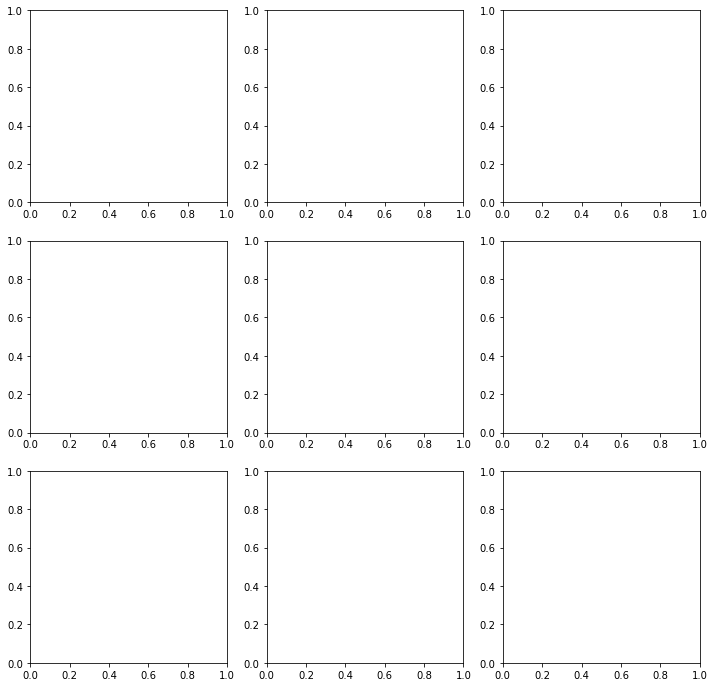

In [6]:
rmse = []
mean_probability = []
plotted_keys = []
mean_depths = []
datapoints = []
transect_count = 0

bw=10
alpha=0.2
counter = 0

fig, axs = plt.subplots(3,3,figsize=(12,12))

for key in dep_l:
    
    station = dep_l[key]
    
    for date in station:

        transect_count += 1

        series = np.array(list(station[date]))
        
        mean_depth = np.nanmean(series)
                
        bins = np.arange(0,np.nanmax(series)+11,bw)

        
        hist, bin_edges = np.histogram(series,bins=bins, density=True)
        
        bc, ft = depth_distribution_from_depth(mean_depth,bins)
        
        
        if (counter < 9) & (len(series) > 100) & (key not in plotted_keys) & (key != 27):
            
            ax = axs.reshape(-1)[counter]
            
            ax.step([0]+list(bc+bw/2),[0]+list(ft),color='r',alpha=0.5)
            ax.step([0]+list(bc+bw/2), [0]+list(hist*bw),color='b',alpha=0.5)
            
            t = ax.bar(bc, hist*bw,
                     width=bw,
                     alpha=alpha,
                     color='b',
                      label='Transect')
            
            m = ax.bar(bc, ft,
                     width=bw,
                     alpha=alpha,
                     color='r',
                      label='NP Model')
            
            ax.annotate(text=f'NP {key}\n{date.year}',xy=(0.95,0.79), xycoords='axes fraction',fontsize='xx-large', ha='right')
            ax.annotate(text=f'({string.ascii_lowercase[counter]})',xy=(0.02,0.90), xycoords='axes fraction',fontsize='xx-large')
            
            if counter > 5: ax.set_xlabel('Snow Depth (cm)', fontsize='xx-large')
            if counter in [0,3,6]: ax.set_ylabel('Probability', fontsize='xx-large')
                
                
            l1 = ax.bar(range(1),range(1),color='b',alpha=0.5)
            l2 = ax.bar(range(1),range(1),color='r',alpha=0.5)
            
            if counter == 1: ax.legend(handles=[l1,l2],labels=['Transect','Model'],
                                       bbox_to_anchor=(0.5,1.2),
                                       loc='center',fontsize='xx-large')
                
            counter +=1
            plotted_keys.append(key)

plt.savefig('../figures/fig2b.png', bbox_inches='tight',dpi=500)

plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/sub-km-snow-depth-dist/fig2b.png', bbox_inches='tight',dpi=500)
        

plt.show()
#         break
#     break